In [52]:
from typing import List
import time
import sklearn.metrics.pairwise as sklearn_pairwise
from sklearn.neighbors import KNeighborsClassifier
import cv2
import numpy as np
from sklearn.cluster import KMeans
import random
import time
from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.vq import kmeans,vq
import matplotlib.pyplot as plt

In [53]:
#!pip install opencv-contrib-python==3.4.2.17

# Load data

In [54]:
!git clone https://github.com/Sejmou/ml-ex3.git

fatal: destination path 'ml-ex3' already exists and is not an empty directory.


In [55]:
ls

AlexNet_CIFAR-10.ipynb        LeNet5_GTSRB.ipynb
AlexNet_GTSRB.ipynb           ml-ex3/
data/                         test.ipynb
Data-Exploration_GTSRB.ipynb  Traditional_Methods_CIFAR-10.ipynb
helper_scripts/               Traditional_Methods_GTSRB.ipynb
LeNet5_CIFAR_10.ipynb


In [56]:
import sys
sys.path.append('./ml-ex3/notebooks/helper_scripts/')# make script files in ml-ex3 accessible

In [57]:
from data_loaders import GTSRBLoader

In [58]:
X_train, X_val, X_test, y_train, y_val, y_test = GTSRBLoader('./data').get_processed_imgs(target_width = 50, target_height = 50, normalize=False, convert_to_grayscale=False)# cannot resize to 257 directly, our implementation is too RAM-hungry

GTSRB dataset already downloaded, loading files from memory
loading training images and labels
loading test images and labels
done
processing training images
processing test images
done processing, creating train/val/test split


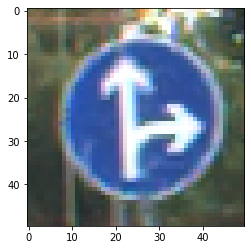

In [59]:
plt.imshow(X_train[1])

# Color Histograms

In [60]:
from PIL import Image

def get_color_hist_from_image(image):
    res = Image.fromarray(image).convert('RGB')
    return res.histogram()

In [61]:
X_train_img = [get_color_hist_from_image(i) for i in X_train]
X_test_img = [get_color_hist_from_image(i) for i in X_test]

In [62]:
from traditional_ml import evaluate_feature

In [63]:
evaluate_feature(X_train_img, y_train, X_test_img, y_test)

Trying KNeighborsClassifier()
Fitted, best are {'clf__n_neighbors': 5, 'clf__weights': 'distance'} with cross val score of 0.7906799324763122.
Accuracy on Test Set is 0.1182897862232779
Trying MLPClassifier()
Fitted, best are {'clf__activation': 'relu', 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate': 'adaptive', 'clf__learning_rate_init': 0.01} with cross val score of 0.45890095143092946.
Accuracy on Test Set is 0.12311955661124308
Trying GaussianNB()
Fitted, best are {} with cross val score of 0.06718642783165271.
Accuracy on Test Set is 0.027711797307996833
Trying DecisionTreeClassifier()
Fitted, best are {'clf__criterion': 'entropy', 'clf__splitter': 'best'} with cross val score of 0.3604530604510893.
Accuracy on Test Set is 0.0889944576405384
Trying RandomForestClassifier(random_state=123)


/home/jakob/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/jakob/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jakob/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jakob/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jakob/.local/lib/python3.8/site

Fitted, best are {'clf__criterion': 'gini', 'clf__n_estimators': 100} with cross val score of 0.734569798646805.
Accuracy on Test Set is 0.16072842438638163
Best Classifier is (RandomForestClassifier(random_state=123), {'clf__criterion': 'gini', 'clf__n_estimators': 100}) with an accuracy of 0.16072842438638163, predicting took 1.831010103225708 seconds and this whole process took 00:35:03.70


In [66]:
from sklearn import ensemble
# Check fit time of optimal model
cl = ensemble.RandomForestClassifier(random_state=123, criterion='gini', n_estimators=100)
ping = time.time()
cl = cl.fit(X_train_img, y_train)
print(f"Fit Time: {time.time()-ping} seconds")

Fit Time: 32.398221015930176 seconds


# SIFT

In [67]:
# reload data with convert_to_grayscale=True
X_train, X_val, X_test, y_train, y_val, y_test = GTSRBLoader('./data').get_processed_imgs(target_width = 50, target_height = 50, normalize=False, convert_to_grayscale=True)# cannot resize to 257 directly, our implementation is too RAM-hungry

GTSRB dataset already downloaded, loading files from memory
loading training images and labels
loading test images and labels
done
processing training images
processing test images
done processing, creating train/val/test split


In [68]:
X_train_int = X_train.astype(np.uint8)
X_test_int = X_test.astype(np.uint8)

## Extract Sift keypoints

In [69]:
def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
    for kp in keypoints:
            x, y = kp.pt
            plt.imshow(cv2.circle(vis, (int(x), int(y)), 2, color),
                       cmap='gray', vmin=0, vmax=255)

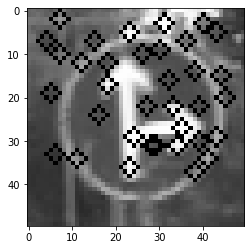

In [70]:
sift=cv2.SIFT_create()
kp = sift.detect(X_train_int[1],None)
kp, des = sift.compute(X_train_int[1], kp)
img=draw_keypoints(X_train_int[1],kp)

In [71]:
def extract_dsift(images):
    sift = cv2.SIFT_create()
    
    all_descriptors = []
    nans = set()
    for i in range(len(images)):
        image = images[i]
        kp = sift.detect(image,None)
        kp, des = sift.compute(image, kp)

        if des is not None:
          all_descriptors.append(des)
        else:
          nans.add(i)

    print(len(nans))
    return all_descriptors, nans

In [72]:
ping = time.time()

sift_features, nans = extract_dsift(X_train_int)
all_descriptors = np.vstack(sift_features)

2073


In [73]:
print(f"Extract sift features time: {time.time()-ping} seconds")

Extract sift features time: 66.16685628890991 seconds


In [74]:
len(X_train)

27446

In [75]:
ping = time.time()
kmeans = KMeans(n_clusters=20).fit(all_descriptors)
print(f"Fit descriptors time: {time.time()-ping} seconds")

Fit descriptors time: 258.4728708267212 seconds


### Creating histogram of training image

In [76]:
def count_visual_words(dense_feat: List[np.ndarray], centroids: List[np.ndarray]) -> List[np.ndarray]:
    histograms = []

    for k in range(0, len(dense_feat)):
        distances = sklearn_pairwise.pairwise_distances(dense_feat[k], centroids)
        clusters = np.argmin(distances, axis=1)
        histogram = np.histogram(clusters, bins = range(len(centroids)))
        histograms.append(histogram[0])

    return histograms

In [77]:
histograms_train = count_visual_words(sift_features, kmeans.cluster_centers_)

In [78]:
def get_data_without_nan(data, nan):
  without_nan = []

  for i in range(len(data)):
    if i not in nan:
      without_nan.append(y_train[i])
      
  return without_nan

In [79]:
y_train_sift = get_data_without_nan(y_train, nans)

In [80]:
ping = time.time()
classifier = KNeighborsClassifier(n_neighbors=5).fit(histograms_train, y_train_sift)
print(f"Fit histograms time: {time.time()-ping} seconds")

Fit histograms time: 0.015543699264526367 seconds


### Testing the Classification Model

In [81]:
prediction_train = classifier.predict(histograms_train)

In [82]:
score = classifier.score(histograms_train, y_train_sift)

In [83]:
print(score)

0.5632759232254759


In [84]:
test_descriptors, test_nan = extract_dsift(X_test_int)
test_histograms = count_visual_words(test_descriptors, kmeans.cluster_centers_)
prediction_test = classifier.predict(test_histograms)

931


In [85]:
y_test_sift = get_data_without_nan(y_test, test_nan)

In [86]:
len(y_test_sift)

11699

In [87]:
score = classifier.score(test_histograms, y_test_sift)

In [88]:
print(score)

0.04137105735532952


In [89]:
evaluate_feature(histograms_train, y_train_sift, test_histograms, y_test_sift)

Trying KNeighborsClassifier()
Fitted, best are {'clf__n_neighbors': 15, 'clf__weights': 'distance'} with cross val score of 0.40606136956298017.
Accuracy on Test Set is 0.041114625181639455
Trying MLPClassifier()
Fitted, best are {'clf__activation': 'relu', 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate': 'adaptive', 'clf__learning_rate_init': 0.01} with cross val score of 0.3900997532091547.
Accuracy on Test Set is 0.03837934866227883
Trying GaussianNB()
Fitted, best are {} with cross val score of 0.21491377077382814.
Accuracy on Test Set is 0.02795110693221643
Trying DecisionTreeClassifier()
Fitted, best are {'clf__criterion': 'gini', 'clf__splitter': 'best'} with cross val score of 0.2561774098028974.
Accuracy on Test Set is 0.036669800837678436
Trying RandomForestClassifier(random_state=123)
Fitted, best are {'clf__criterion': 'gini', 'clf__n_estimators': 100} with cross val score of 0.4173724910730062.
Accuracy on Test Set is 0.040601760834259336
Best Classifier is (KNeigh

In [91]:
sifcl = KNeighborsClassifier(n_neighbors=20, weights='distance')
ping = time.time()
cl = cl.fit(histograms_train, y_train_sift)
print(f"Fit Time: {time.time()-ping} seconds")

Fit Time: 0.013900279998779297 seconds


/home/jakob/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jakob/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
